# Exercise 1 computer assignments

Fill in the parts labeled **your solution here** and replace *...* with your code. You *do not* need to strictly follow the template, but you may lose points if you do not provide the required results.

## 1 Basic definitions

In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### (a)

In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class Net(nn.Module):
    def __init__(self, foo) -> None: 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 5),
            foo,
            nn.Linear(5, 5),
            foo,
            nn.Linear(5, 5),
            foo            
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layers(x)
    
tanhnet = Net(nn.Tanh()).to(device)
relunet = Net(nn.ReLU()).to(device)
linearnet = Net(nn.Identity()).to(device)

In [22]:
torch.manual_seed(1)

x = torch.randn(5, device=device)
#print(tanhnet(x))
#print(relunet(x))
#print(linearnet(x))

print(tanhnet)

for param in tanhnet.parameters():
    print(param)
    print()



Net(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Tanh()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): Tanh()
  )
)
Parameter containing:
tensor([[ 0.4150,  0.0326, -0.4365, -0.1716,  0.2222],
        [-0.3711,  0.0825,  0.3143,  0.0620,  0.3703],
        [-0.0847, -0.1224, -0.2912,  0.2823,  0.3216],
        [-0.0175,  0.2605, -0.1468, -0.0284,  0.3814],
        [-0.0600, -0.0173, -0.2102, -0.3582, -0.2514]], device='cuda:0',
       requires_grad=True)

Parameter containing:
tensor([ 0.1481,  0.3361, -0.0583, -0.2993,  0.1233], device='cuda:0',
       requires_grad=True)

Parameter containing:
tensor([[ 0.4459, -0.2415,  0.0794, -0.2868,  0.4291],
        [-0.3245, -0.3735,  0.2466, -0.1649,  0.0694],
        [ 0.3915, -0.0749, -0.1860, -0.1500,  0.1709],
        [ 0.3364,  0.2691,  0.3941,  0.0515, -0.4133],
        [ 0.0153, -0.3496,  0.0206,  

#### (b)

In [ ]:
...

# Code for reporting the 9 plots:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
for i in range(3): # loop over rows of plot
    ...
    for j in range(3): # loop over cols of plot
        ...
        axs[i, j].plot(...)
        axs[i, j].set_title(...)
        axs[i, j].set_xlabel('x1')
        axs[i, j].set_ylabel('y1')
plt.tight_layout()
plt.show()

## 2 Optimization

### 1.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import copy

np.random.seed(1)

#### (a)

In [129]:
def f(w: np.array) -> float:
    return np.exp(-w[0]**2 - 2*(w[1] - 1)**2) + np.exp(-(w[0] - 1)**2 - 2*w[1]**2)

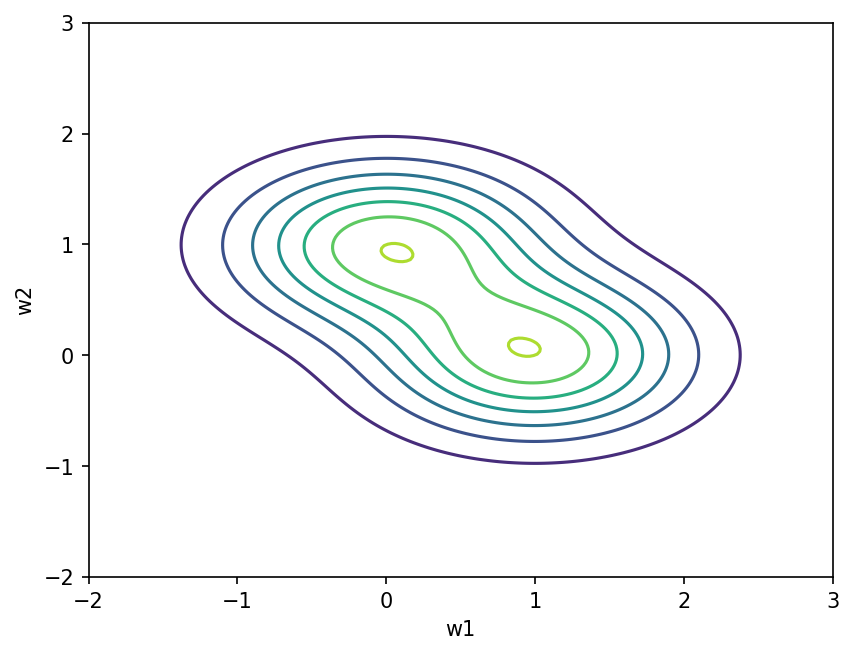

In [13]:

# Code for plotting isocontours of the function f
vec_f = np.vectorize(f, signature="(n)->()")
w1 = np.linspace(-2.0, 3.0, 200)
w2 = np.linspace(-2.0, 3.0, 200)
W1, W2 = np.meshgrid(w1, w2)
Fs = vec_f(np.stack((W1, W2), axis=2))
plt.figure(dpi=150)
plt.contour(W1, W2, Fs)
plt.xlabel("w1")
plt.ylabel("w2")
plt.show()

#### (b)

$$
\begin{align*}
f(\textbf{w})&=\exp (-w_1^2 - 2(w_2 - 1)^2) + \exp (-(w_1-1)^2-2w_2) \\
&= \exp (-w_1^2 - 2w_2^2 + 4w_2 -2) + \exp (-w_1^2+2w_1-2w_2^2-1) 
\end{align*}
$$

The gradient is then
$$
\begin{align*}
\nabla f &=\frac{\partial f}{\partial w_1} \textbf{i} + \frac{\partial f}{\partial w_2} \textbf{j} \\
&= \left[ -2w_1 \exp (-w_1^2 -2w_2^2 + 4w_2 -2 ) + (2 - 2w_1) \exp (-w_1^2 + 2w_1 -2w_2^2 -1) \right] \textbf{i} \\
&+ \left[ (4 -4w_2)\exp (-w_1^2 -2w_2^2 + 4w_2 -2 ) - 4w_2 \exp (-w_1^2 + 2w_1 -2w_2^2 -1) \right] \textbf{j}
\end{align*}
$$

In [130]:
def grad_f(w: np.array) -> np.array:
    w1, w2 = w[0], w[1]
    i = -2*w1*np.exp(-w1**2 - 2*w2**2 + 4*w2 - 2) + (2 - 2*w1)*np.exp(-w1**2 + 2*w1 - 2*w2**2 - 1)
    j = (4 - 4*w2)*np.exp(-w1**2 - 2*w2**2 + 4*w2 - 2) - 4*w2*np.exp(-w1**2 + 2*w1 - 2*w2**2 - 1)
    return np.array(i, j)

#### (c)

In [133]:
w1 = np.asarray([0.2, 0.5])
w2 = np.asarray([0.5, 0.2])
w3 = np.asarray([1.0, 1.0])

def gradient_method(w_init: np.array, stepsize: float) -> tuple[list, list]:
    w = w_init
    w_vals = [w]
    f_vals = [f(w)]
    while True:
        w = w + stepsize*grad_f(w)
        w_vals.append(w) 
        f_vals.append(f(w))
        # stop when the vector w doesn't change significantly anymore
        if np.abs(w_vals[-1][0] - w_vals[-2][0]) < 0.0001 and np.abs(w_vals[-1][1] - w_vals[-2][1]) < 0.0001:
            break

    return (w_vals, f_vals)

step1 = 0.05
step2 = 0.001
step3 = 0.1

#l = [gradient_method(w, 0.001) for w in [w1, w2, w3]]
w_vals1, f_vals1 = gradient_method(w1, step1)
w_vals2, f_vals2 = gradient_method(w2, step2)
w_vals3, f_vals3 = gradient_method(w3, step3)
#len(l)

w_vals = [w_vals1, w_vals2, w_vals3]
f_vals = [f_vals1, f_vals2, f_vals3]

#### (d)

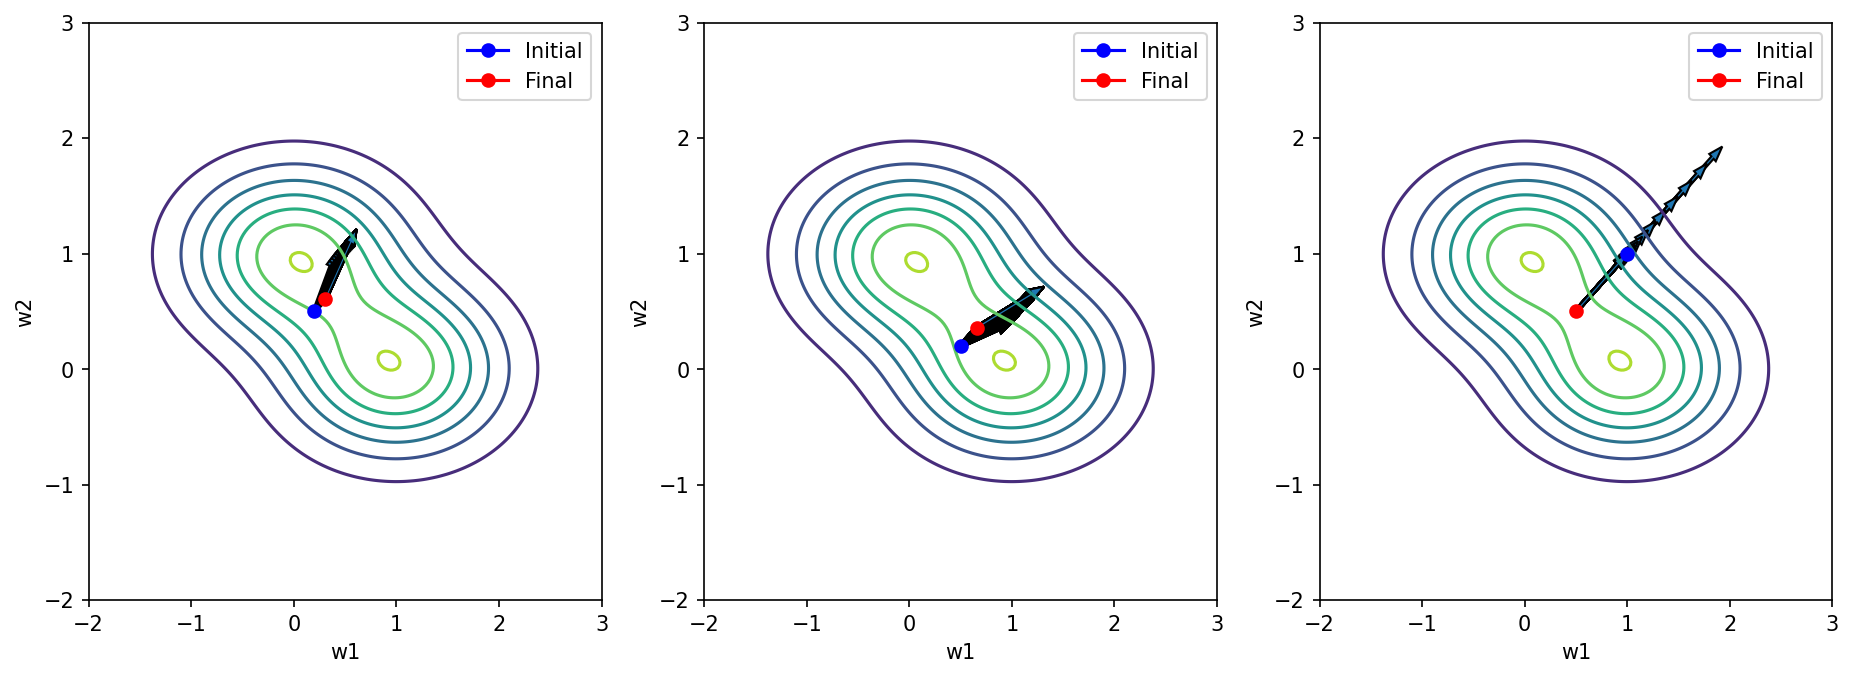

In [127]:
# Code for plotting.
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)
for i, w in enumerate(w_vals):
    ax = axes[i]
    ax.contour(W1, W2, Fs)
    ax.plot(w[0][0], w[0][1], marker="o", color="blue", label="Initial")
    for j in range(len(w) - 1):
        ax.arrow(w[j][0], w[j][1], w[j+1][0], w[j+1][1], length_includes_head=True, width=0.03)
    ax.plot(w[-1][0], w[-1][1], marker="o", color="red", label="Final")
    ax.set_xlabel("w1")
    ax.set_ylabel("w2")
    ax.legend()
plt.show()

#### (e)

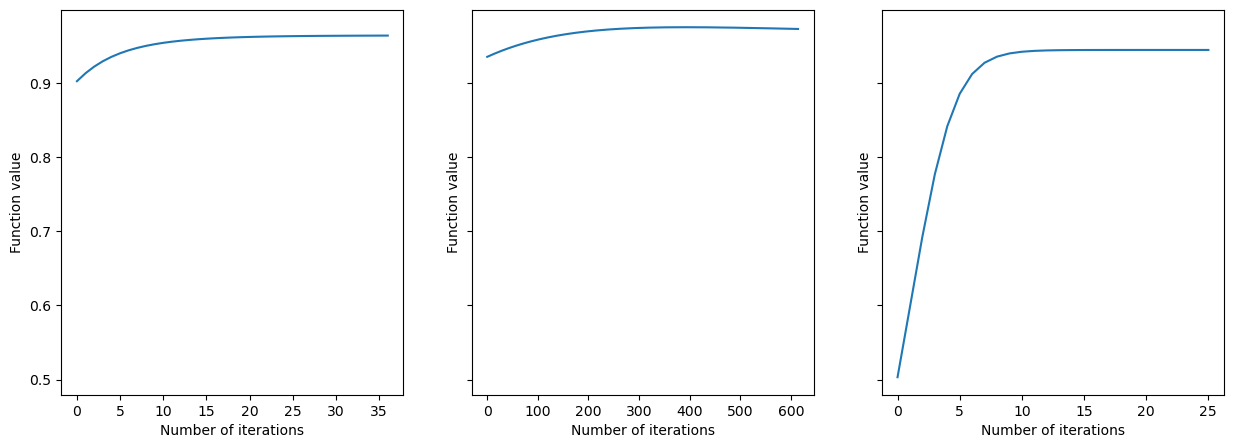

In [128]:
# Code for plotting.
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, vals in enumerate(f_vals):
    axs[i].plot(range(len(vals)), vals)
    axs[i].set_xlabel("Number of iterations")
    axs[i].set_ylabel("Function value")
plt.show()

#### (f)

The function seems to converge to a local maximum in all three cases. How fast it does so depends on the starting point and the step size $\mu$. In the first and third case the stepsize can be bigger and the algorithm converges quite rapidly, but in the second case the step size needs to be smaller since the changes in the values of $f$ are more volatile. This is reflected in the number of iterations. This illustrates how easily the gradient method can be trapped in local extrema and the difficulty of optimization in general when the objective function is not simple and "well-behaved". 